# Telecom Churn Prediction - Case Study

## Problem Statement

The case study's purpose is to create ML models that anticipate churn. The prediction model will be used to do the following:
1. It will be used to anticipate whether or not a high-value customer would churn in the near future (i.e. the churn phase). Knowing this allows the corporation to take action, such as offering special programmes, discounts on recharge, and so on.
2. It will be utilised to discover key variables that are significant predictors of churn. These criteria may also suggest why customers decide to switch networks.
3. While overall accuracy will be your major assessment metric, you should also provide other metrics such as precision, recall, and so on for the various models that can be utilised for evaluation reasons based on different business objectives. For example, in this issue statement, one business goal could be to construct an ML model that detects consumers who would surely churn with greater accuracy than those who will not churn. Make sure to specify which metrics can be used in such instances.
4. Based on your insights, provide measures to manage customer attrition.

### Datasets

| Name                                                                                               | Description                                                      |
| -------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------- |
| [unseen](https://github.com/rahul-nanwani/TelecomChurn/blob/master/dataset/test.csv)               | The test data that we will have to predict the churn for.        |
| [sample](https://github.com/rahul-nanwani/TelecomChurn/blob/master/dataset/sample.csv)             | Sample of the expected output.                                   |
| [data_dict](https://github.com/rahul-nanwani/TelecomChurn/blob/master/dataset/data_dictionary.csv) | Defines the meaning of each column present in the provided data. |
| data                                                                                               | Actual data provided to train and evaluate the model.            |


## Steps
1. Data Understanding, Preparation, and Pre-Processing
2. Exploratory Data Analysis
3. Feature Engineering and Variable Transformation
4. Model Selection, Model Building, and Prediction

## Step 0: Pre-requisites

This notebook was run on python v3.10.9

The following are the required libraries:

| Library      | Version |
| ------------ | ------- |
| numpy        | 1.23.5  |
| pandas       | 1.5.3   |
| matplotlib   | 3.7.0   |
| seaborn      | 0.12.2  |
| scikit-learn | 1.2.1   |
| xgboost      | 1.7.6   |


Importing all the required libraries for the case study.

In [1]:
# General
import json
import os
import ssl
import multiprocessing
import numpy as np
import pandas as pd
from typing import Any, Iterable, Optional, Text

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Imputation
from sklearn.impute import KNNImputer

# Scaling
from sklearn.preprocessing import MinMaxScaler

# Feature Enginnering
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, RFE
from sklearn.linear_model import LassoCV, Lasso

# Classification / Prediction
from sklearn.ensemble import (
    AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRFClassifier

# Modelling
from sklearn.metrics import (accuracy_score, roc_auc_score,
                             precision_score, recall_score, precision_recall_curve)
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, train_test_split)
from sklearn.pipeline import Pipeline


Code to handle SSL configuration.

In [2]:
if not os.environ.get("PYTHONHTTPSVERIFY", "") and getattr(ssl, "_create_unverified_context", None):
    ssl._create_default_https_context = ssl._create_unverified_context


GitHub does not allow files of more than 25mb to be uploaded, so I have divided the *train.csv* into 3 parts, that we will combine into a single dataframe.

In [3]:
train_csv_urls = [
    "https://raw.githubusercontent.com/rahul-nanwani/TelecomChurn/master/dataset/train_part_1.csv",
    "https://raw.githubusercontent.com/rahul-nanwani/TelecomChurn/master/dataset/train_part_2.csv",
    "https://raw.githubusercontent.com/rahul-nanwani/TelecomChurn/master/dataset/train_part_3.csv"
]

train_dfs = []

for csv_url in train_csv_urls:
    train_dfs.append(pd.read_csv(csv_url))

data = pd.concat(train_dfs, axis=0)
data.reset_index(inplace=True, drop=True)


## Step 1: Data Understanding, Preparation, and Pre-Processing

In [4]:
data.shape


(69999, 172)

In [5]:
data.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [6]:
data.set_index("id", inplace=True)


Let us now check for the count of unique values in a column. Columns with just one unqiue value will not benefit us so we can drop those, as these columns have no variance.

In [7]:
data = data.loc[:, data.nunique() != 1]


In [8]:
data.shape


(69999, 158)

Check the columns with the missing data greater than 30%.

In [9]:
missing_values = data.isna().mean().sort_values(ascending=False)
high_missing_values = missing_values[missing_values > 0.3]

high_missing_values


av_rech_amt_data_6          0.749025
count_rech_3g_6             0.749025
arpu_3g_6                   0.749025
arpu_2g_6                   0.749025
max_rech_data_6             0.749025
night_pck_user_6            0.749025
count_rech_2g_6             0.749025
date_of_last_rech_data_6    0.749025
total_rech_data_6           0.749025
fb_user_6                   0.749025
max_rech_data_7             0.744782
date_of_last_rech_data_7    0.744782
count_rech_2g_7             0.744782
arpu_3g_7                   0.744782
count_rech_3g_7             0.744782
av_rech_amt_data_7          0.744782
fb_user_7                   0.744782
night_pck_user_7            0.744782
arpu_2g_7                   0.744782
total_rech_data_7           0.744782
fb_user_8                   0.736896
arpu_3g_8                   0.736896
date_of_last_rech_data_8    0.736896
total_rech_data_8           0.736896
count_rech_2g_8             0.736896
count_rech_3g_8             0.736896
av_rech_amt_data_8          0.736896
n

In [10]:
data[high_missing_values.index].describe()


,av_rech_amt_data_6,count_rech_3g_6,arpu_3g_6,arpu_2g_6,max_rech_data_6,night_pck_user_6,count_rech_2g_6,total_rech_data_6,fb_user_6,max_rech_data_7,...,total_rech_data_7,fb_user_8,arpu_3g_8,total_rech_data_8,count_rech_2g_8,count_rech_3g_8,av_rech_amt_data_8,night_pck_user_8,max_rech_data_8,arpu_2g_8
count,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17568.000000,17865.000000,...,17865.000000,18417.000000,18417.000000,18417.000000,18417.000000,18417.000000,18417.000000,18417.000000,18417.000000,18417.000000
mean,192.831096,0.602288,90.069931,86.863900,126.500000,0.025273,1.865323,2.467612,0.916325,126.402071,...,2.679989,0.890319,90.618564,2.652441,2.016018,0.636423,196.815792,0.021013,125.374925,86.348404
std,190.623115,1.279297,193.600413,171.321203,109.352573,0.156958,2.566377,2.794610,0.276907,109.459266,...,3.073472,0.312501,189.907986,3.101265,2.728246,1.457058,192.280532,0.143432,109.648799,170.297094
min,1.000000,0.000000,-20.380000,-35.830000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,-24.490000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-55.830000
25%,82.000000,0.000000,0.000000,0.000000,25.000000,0.000000,1.000000,1.000000,1.000000,25.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,84.000000,0.000000,25.000000,0.000000
50%,154.000000,0.000000,0.520000,11.300000,145.000000,0.000000,1.000000,1.000000,1.000000,145.000000,...,2.000000,1.000000,0.840000,1.000000,1.000000,0.000000,154.000000,0.000000,145.000000,9.090000
75%,252.000000,1.000000,122.070000,122.070000,177.000000,0.000000,2.000000,3.000000,1.000000,177.000000,...,3.000000,1.000000,122.070000,3.000000,2.000000,1.000000,252.000000,0.000000,179.000000,122.070000
max,5920.000000,29.000000,5054.370000,5054.350000,1555.000000,1.000000,42.000000,61.000000,1.000000,1555.000000,...,54.000000,1.000000,3716.900000,60.000000,44.000000,45.000000,4076.000000,1.000000,1555.000000,3483.170000


In the recharge variables where the minumum value is 1, we can impute missing values with 0 assuming that it means customer did not recharge in that month.

In [11]:
columns_to_impute = [
    "total_rech_data_6",
    "total_rech_data_7",
    "total_rech_data_8",
    "av_rech_amt_data_6",
    "av_rech_amt_data_7",
    "av_rech_amt_data_8",
    "max_rech_data_6",
    "max_rech_data_7",
    "max_rech_data_8",
]

data[columns_to_impute] = data[columns_to_impute].fillna(0)


We will replace missing values in the categorical values with `-1`, where `-1` will be a new category.

In [12]:
categorical_cols = [
    "night_pck_user_6",
    "night_pck_user_7",
    "night_pck_user_8",
    "fb_user_6",
    "fb_user_7",
    "fb_user_8",
]

data[categorical_cols] = data[categorical_cols].fillna(-1)


Now we can drop the remaining columns with high missing data i.e. greater than 30%.

In [13]:
data = data.loc[:, data.isna().mean() <= 0.3]


In [14]:
data.shape


(69999, 143)

In [15]:
data.describe(include="object")


,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
count,68898,68765,67538
unique,30,31,31
top,6/30/2014,7/31/2014,8/31/2014
freq,11880,12206,10324


We don't find these columns to be helpful to us, so we can drop these.

In [16]:
data.drop(columns=["date_of_last_rech_6",
          "date_of_last_rech_7", "date_of_last_rech_8"], inplace=True)


Derive a new variable avg_arpu to find the high value customers and keep the ones at or above 0.7 quantile.

In [17]:
data["avg_arpu"] = data[["arpu_6", "arpu_7", "arpu_8"]].sum(axis=1)/3
data = data.loc[data["avg_arpu"] >= data["avg_arpu"].quantile(0.7), :]

data.drop("avg_arpu", axis=1, inplace=True)

data.shape


(21000, 140)

### Train-Test Split

Split the train and test data.

In [18]:
X_train, X_test = train_test_split(
    data, train_size=0.8, random_state=42, stratify=data["churn_probability"])

X_train.shape, X_test.shape


((16800, 140), (4200, 140))

Aggregate the values for the categorical columns.

In [19]:
mapping = {}

for col in categorical_cols:
    means = list(X_train.groupby(col)["churn_probability"].mean())
    mapping[col] = {
        -1: means[0],
        0: means[1],
        1: means[2]
    }

X_train.replace(mapping, inplace=True)
X_test.replace(mapping, inplace=True)


Separate the target variable from the data, and before apply any transformation let us make a copy of train and test data for final evaluation. `train_records` is a copy that includes the target variable, this can be used for EDA.

In [20]:
train_records = X_train.copy()

y_train = X_train.pop("churn_probability")
y_test = X_test.pop("churn_probability")

X_train_raw = X_train.copy()
X_test_raw = X_test.copy()


### Imputer

#### KNN Imputer

Impute the remaining missing values using KNNImputer.

In [21]:
knn_imputer = KNNImputer(n_neighbors=5, weights="distance")

X_train = pd.DataFrame(
    knn_imputer.fit_transform(X_train, y_test),
    columns=knn_imputer.get_feature_names_out())
X_test = pd.DataFrame(
    knn_imputer.transform(X_test),
    columns=knn_imputer.get_feature_names_out())


## Step 2: Exploratory Data Analysis

Let us pick top 10 correlated variables with the target variable and analyse them.
Include till 11th as we need to include the target variable as well.

In [22]:
churn_correlation = train_records.corr()["churn_probability"]

churn_correlation = abs(churn_correlation).sort_values(ascending=False)
churn_correlation = list(churn_correlation.index)

top_10_correlated = churn_correlation[:11]


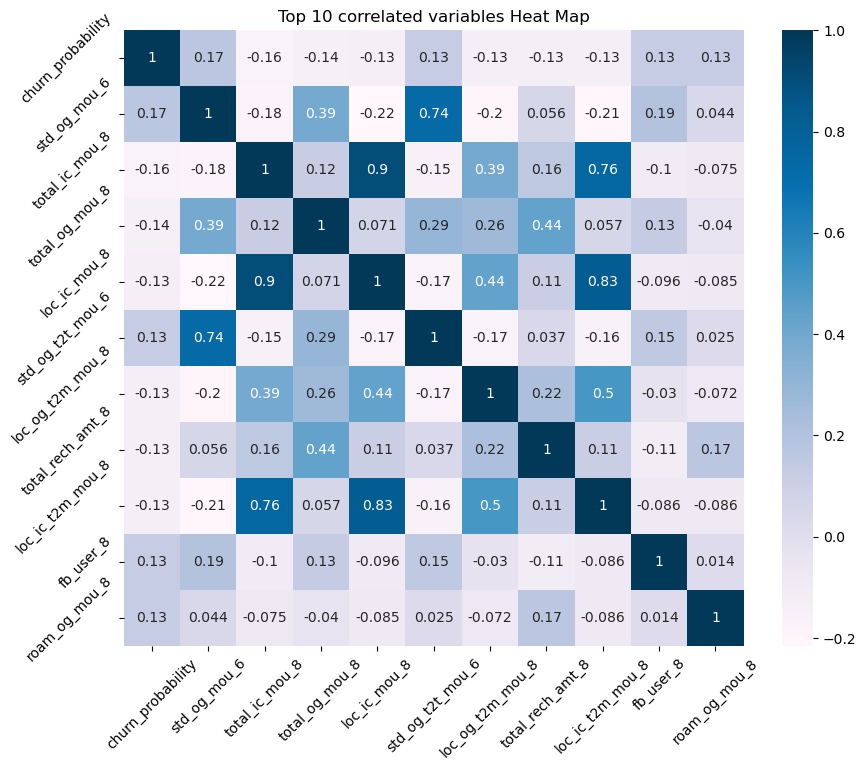

In [23]:
plt.figure(figsize=(10, 8))

sns.heatmap(train_records[top_10_correlated].corr(), cmap="PuBu", annot=True)

plt.title("Top 10 correlated variables Heat Map")
plt.yticks(rotation=45)
plt.xticks(rotation=45)

plt.show()


We see some multi-colinerailty between the features. And the features do not have strong correlation with the target variable.

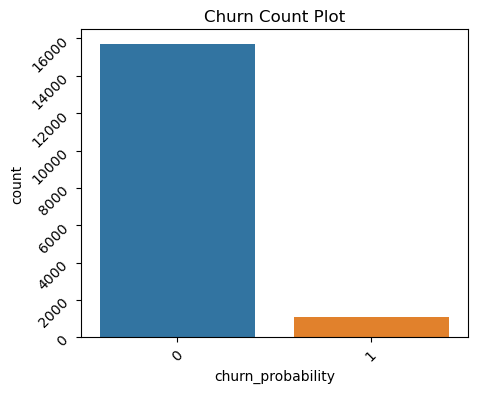

In [24]:
plt.figure(figsize=(5, 4))

sns.countplot(x="churn_probability", data=train_records)

plt.title("Churn Count Plot")
plt.tick_params(labelrotation=45)

plt.show()


We can see that a very small set of people churn. We will need to adjust the class weights accordingly.

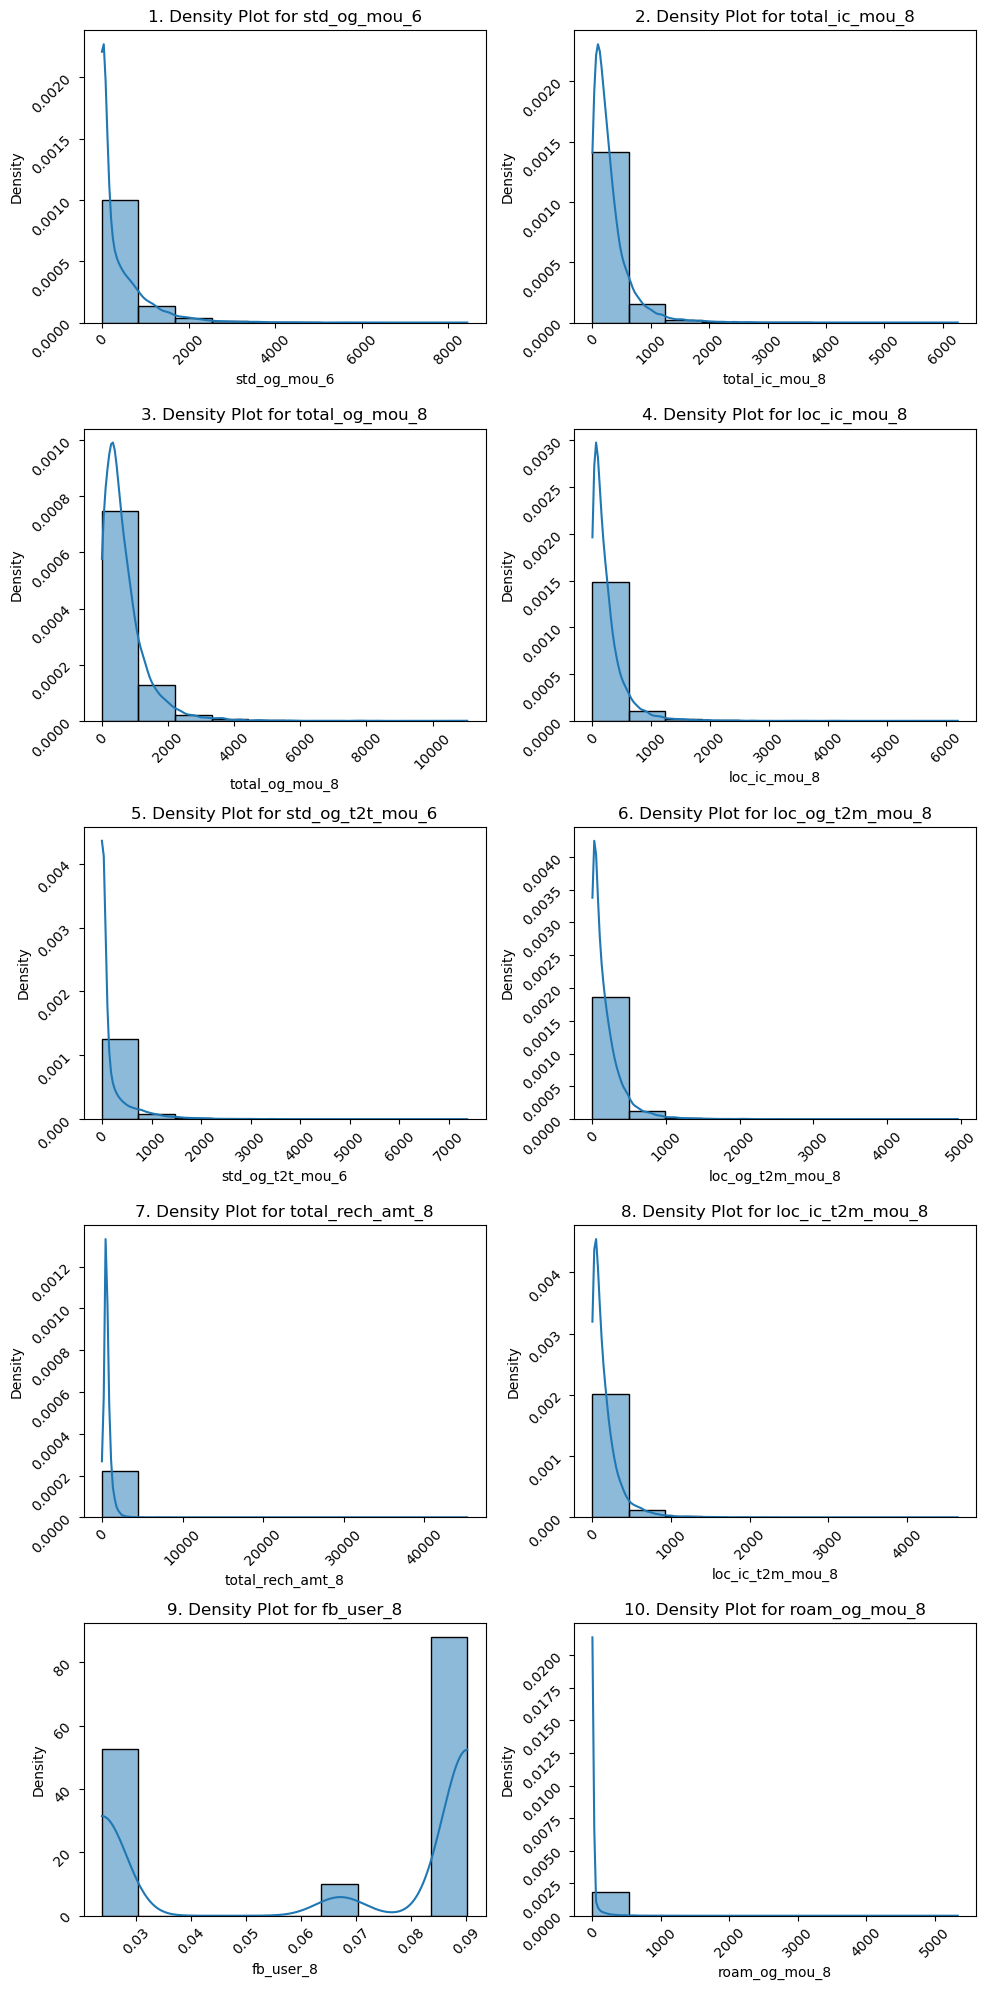

In [25]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
subplots = axs.flatten()

for idx, col in enumerate(top_10_correlated[1:]):
    ax = subplots[idx]

    sns.histplot(x=train_records[col], ax=ax,
                 stat="density", kde=True, bins=10)

    ax.set_title(f"{idx+1}. Density Plot for {col}")
    ax.tick_params(labelrotation=45)

plt.tight_layout()
plt.show()


We can see that the most of the features are skewed towards the left.

## Step 3: Feature Engineering and Variable Transformation

### Scaling

#### Min-Max Scaler

Scale the data using min-max scaler.

In [26]:
minmax_scaler = MinMaxScaler()

X_train = pd.DataFrame(minmax_scaler.fit_transform(
    X_train, y_train), columns=minmax_scaler.get_feature_names_out())
X_test = pd.DataFrame(minmax_scaler.transform(
    X_test), columns=minmax_scaler.get_feature_names_out())


### Dimensionality Reduction

#### PCA - Principal Component Analysis

Dimensionality reduction using PCA, as we have a lot of features. We will try to keep 99% of the variance.

In [27]:
pca_model = PCA(
    n_components=0.99, svd_solver="full",
    random_state=42)

pca_model.fit(X_train, y_train)


PCA(n_components=0.99, random_state=42, svd_solver='full')

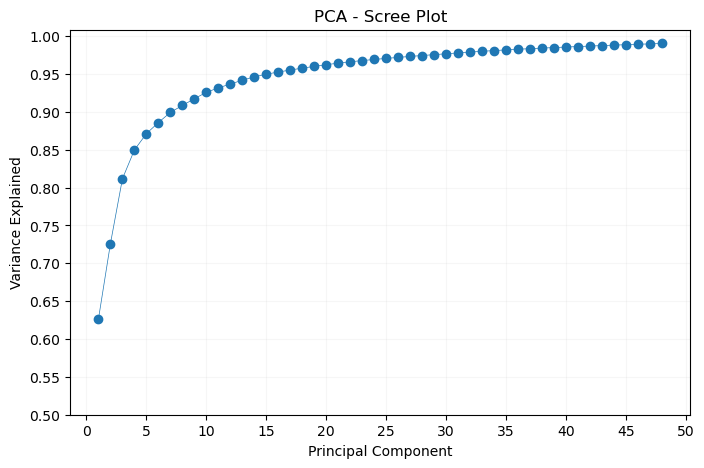

In [28]:
plt.figure(figsize=(8, 5))

plt.plot(
    np.arange(pca_model.n_components_) + 1,
    np.cumsum(pca_model.explained_variance_ratio_),
    "o-", linewidth=0.5
)

plt.grid(True, alpha=0.1)
plt.title("PCA - Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.xticks(np.arange(pca_model.n_components_+5, step=5))
plt.yticks(np.arange(0.5, 1.05, step=0.05))

plt.show()


Now we have about 50 principal components we can do feature selection on this.

In [29]:
X_train = pd.DataFrame(pca_model.transform(
    X_train), columns=pca_model.get_feature_names_out())
X_test = pd.DataFrame(pca_model.transform(
    X_test), columns=pca_model.get_feature_names_out())


### Feature Selection

Calculate the number of processes to run parallelly.

In [30]:
n_jobs = multiprocessing.cpu_count()-1


#### Regularization

##### Lasso Regularization

In [31]:
lasso_cv = LassoCV(cv=StratifiedKFold(), random_state=42, n_jobs=n_jobs)

lasso_cv.fit(X_train, y_train)


LassoCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
        n_jobs=7, random_state=42)

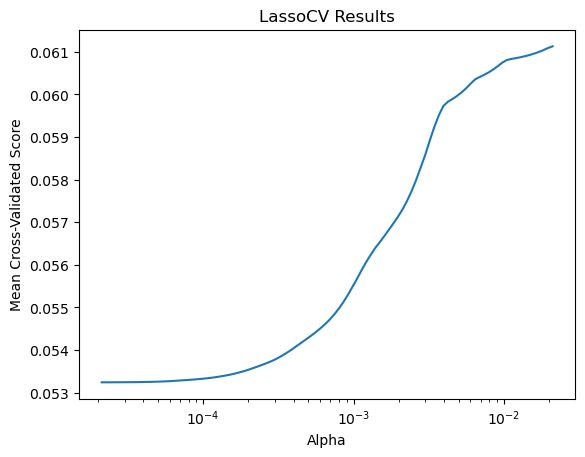

In [32]:
alphas = lasso_cv.alphas_
mean_scores = np.mean(lasso_cv.mse_path_, axis=1)

plt.plot(alphas, mean_scores)
plt.xlabel('Alpha')
plt.ylabel('Mean Cross-Validated Score')
plt.title('LassoCV Results')
plt.xscale('log')
plt.show()


We can now fine tune the alpha around the stable region.

In [33]:
lasso_model = Lasso(random_state=42)

params = {
    "alpha": np.logspace(-4, 0, num=10)
}

grid_search = GridSearchCV(
    estimator=lasso_model,
    cv=StratifiedKFold(),
    param_grid=params,
    n_jobs=n_jobs,
    verbose=1
)

grid_search.fit(X_train, y_train)
lasso_model = grid_search.best_estimator_

print("Best hyperparameters: ")
print(json.dumps(grid_search.best_params_, indent=2))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: 
{
  "alpha": 0.0001
}


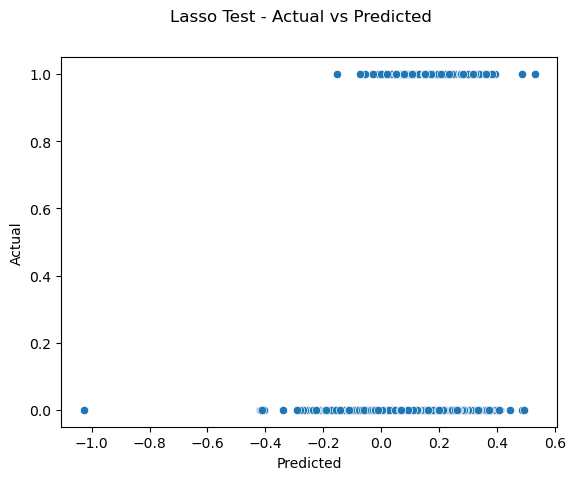

In [34]:
sns.scatterplot(x=lasso_model.predict(X_test), y=y_test)

plt.suptitle("Lasso Test - Actual vs Predicted")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()


The above could be a sign of underfitting, where the model is not capturing the underlying patterns and relationships in the data adequately.

#### Recursive Feature Elimination

In [35]:
rfe_estimator = RandomForestClassifier(
    class_weight="balanced", criterion="entropy",
    min_samples_split=5, min_samples_leaf=2,
    random_state=42, n_jobs=n_jobs)

rfe_selector = RFECV(
    estimator=rfe_estimator, cv=StratifiedKFold(),
    n_jobs=n_jobs)

rfe_selector.fit(X_train, y_train)
print(f"Optimal number of features: {rfe_selector.n_features_}")


Optimal number of features: 23


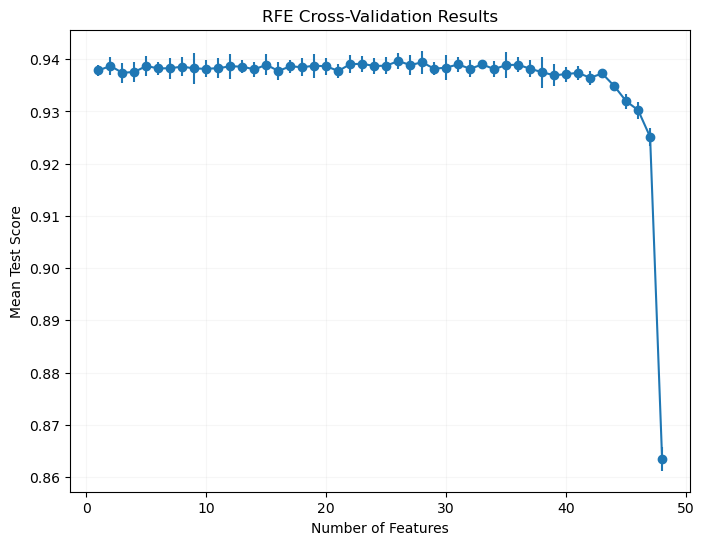

In [36]:
num_features = len(rfe_selector.cv_results_['mean_test_score'])
x = range(num_features, 0, -1)
y_mean = rfe_selector.cv_results_['mean_test_score']
y_std = rfe_selector.cv_results_['std_test_score']

plt.figure(figsize=(8, 6))
plt.errorbar(x, y_mean, yerr=y_std, fmt='-o')

plt.xlabel("Number of Features")
plt.ylabel("Mean Test Score")
plt.title("RFE Cross-Validation Results")
plt.grid(True, alpha=0.1)
plt.show()


In [37]:
rfe_features = pd.DataFrame({
    "Feature": rfe_selector.feature_names_in_,
    "Support": rfe_selector.support_,
    "Rank": rfe_selector.ranking_
})

rfe_features.sort_values(by="Rank", ascending=False, inplace=True)
rfe_features[rfe_features["Support"] == True]


,Feature,Support,Rank
23,pca23,True,1
10,pca10,True,1
2,pca2,True,1
45,pca45,True,1
3,pca3,True,1
4,pca4,True,1
5,pca5,True,1
41,pca41,True,1
6,pca6,True,1
7,pca7,True,1


In [38]:
rfe_selector = RFE(estimator=rfe_estimator,
                   n_features_to_select=rfe_selector.n_features_)

X_train = pd.DataFrame(rfe_selector.fit_transform(
    X_train, y_train), columns=rfe_selector.get_feature_names_out())
X_test = pd.DataFrame(rfe_selector.transform(
    X_test), columns=rfe_selector.get_feature_names_out())


## Step 4: Model Selection, Model Building, and Prediction

### Helper Functions

In [39]:
metrics = pd.DataFrame(columns=[
    "Model", "Train Accuracy", "Test Accuracy",
    "Train ROC AUC", "Test ROC AUC",
    "Train Precision", "Test Precision",
    "Train Recall", "Test Recall"
])


def get_metrics(model: Any, model_name: Optional[Text] = None,
                **kwargs: Any) -> pd.DataFrame:
    """
    Get the model metrics on train and test data, and update the
    metrics dataframe. Metrics include:
    - Accuracy
    - ROC AUC Score
    - Precision
    - Recall

        Args:
            model: Any compatible fitted model that has 'predict' method.
            model_name: Optional name of the model to be appended in the
            metrics dataframe.
        Keyword Args:
            X_train: X train data
            X_test: X test data
            y_train: y train data
            y_test: y test data
        Returns:
            The updated metrics dataframe.
    """

    if model_name is None:
        model_name = type(model).__name__

    _X_train = kwargs.get("X_train", X_train)
    _y_train = kwargs.get("y_train", y_train)

    _X_test = kwargs.get("X_test", X_test)
    _y_test = kwargs.get("y_test", y_test)

    _y_train_pred = model.predict(_X_train)
    _y_test_pred = model.predict(_X_test)

    _train_accuracy = accuracy_score(_y_train, _y_train_pred)
    _train_roc_auc = roc_auc_score(_y_train, _y_train_pred)
    _train_precision = precision_score(
        _y_train, _y_train_pred, zero_division=0)
    _train_recall = recall_score(_y_train, _y_train_pred, zero_division=0)

    _test_accuracy = accuracy_score(_y_test, _y_test_pred)
    _test_roc_auc = roc_auc_score(_y_test, _y_test_pred)
    _test_precision = precision_score(_y_test, _y_test_pred, zero_division=0)
    _test_recall = recall_score(_y_test, _y_test_pred, zero_division=0)

    _metrics = np.array([
        _train_accuracy, _test_accuracy,
        _train_roc_auc, _test_roc_auc,
        _train_precision, _test_precision,
        _train_recall, _test_recall
    ])
    _metrics = np.round(_metrics, 3)
    metrics.loc[len(metrics.index)] = [model_name, *list(_metrics)]

    return metrics


In [40]:
def metrics_plot(model_names: Optional[Iterable] = None) -> None:
    """
    Plot a comparision plot for the metrics DataFrame.

        Args:
            model_names: Optional iterable to filter
            the plot to compare specific models.
        Returns:
            None
    """

    _metrics_df = metrics.copy()

    if model_names is not None:
        _metrics_df = _metrics_df[_metrics_df["Model"].isin(model_names)]

    _metrics_categories = [
        (["Model", "Train Accuracy", "Test Accuracy"], "Accuracy"),
        (["Model", "Train ROC AUC", "Test ROC AUC"], "ROC AUC Score"),
        (["Model", "Train Precision", "Test Precision",
          "Train Recall", "Test Recall"], "Precision and Recall")
    ]

    _plot_width = (2 * len(_metrics_df["Model"])) + 1
    _, _axs = plt.subplots(nrows=3, ncols=1, figsize=(_plot_width, 12))
    _subplots = _axs.flatten()

    for _idx, (_category, _title) in enumerate(_metrics_categories):
        _ax = _subplots[_idx]

        _melted_df = _metrics_df[_category].melt(
            id_vars="Model", var_name="Metric", value_name="Score")
        sns.barplot(data=_melted_df, x="Model", y="Score", hue="Metric",
                    palette=["#0045a5", "#ffa600"], width=0.75, ax=_ax)

        _ax.set_title(f"Model Performance Comparison - {_title}")
        _ax.set_yticks(np.arange(1.1, step=0.1))
        _ax.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

    return None


### Classification / Prediction Models

#### Logistic Regression

In [41]:
logistic_model = LogisticRegression(
    class_weight={0: 0.05, 1: 0.95}, C=10, penalty="l1",
    solver="liblinear", random_state=42)

logistic_model.fit(X_train, y_train)
get_metrics(logistic_model)


,Model,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train Precision,Test Precision,Train Recall,Test Recall
0,LogisticRegression,0.735,0.733,0.787,0.771,0.179,0.173,0.847,0.815


#### Gaussian Naive Bayes Classifier

In [42]:
gnb_model = GaussianNB()

gnb_model.fit(X_train, y_train)
get_metrics(gnb_model)


,Model,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train Precision,Test Precision,Train Recall,Test Recall
0,LogisticRegression,0.735,0.733,0.787,0.771,0.179,0.173,0.847,0.815
1,GaussianNB,0.902,0.901,0.617,0.599,0.270,0.249,0.288,0.251


#### Decision Tree

In [43]:
dt_model = DecisionTreeClassifier(
    class_weight={0: 0.05, 1: 0.95}, criterion="entropy",
    max_depth=10, random_state=42)

dt_model.fit(X_train, y_train)
get_metrics(dt_model)


,Model,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train Precision,Test Precision,Train Recall,Test Recall
0,LogisticRegression,0.735,0.733,0.787,0.771,0.179,0.173,0.847,0.815
1,GaussianNB,0.902,0.901,0.617,0.599,0.270,0.249,0.288,0.251
2,DecisionTreeClassifier,0.874,0.825,0.894,0.685,0.333,0.192,0.916,0.524


#### KNN Classifier

In [44]:
knn_model = KNeighborsClassifier(weights="distance", n_jobs=n_jobs)

knn_model.fit(X_train, y_train)
get_metrics(knn_model)


,Model,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train Precision,Test Precision,Train Recall,Test Recall
0,LogisticRegression,0.735,0.733,0.787,0.771,0.179,0.173,0.847,0.815
1,GaussianNB,0.902,0.901,0.617,0.599,0.270,0.249,0.288,0.251
2,DecisionTreeClassifier,0.874,0.825,0.894,0.685,0.333,0.192,0.916,0.524
3,KNeighborsClassifier,1.000,0.935,1.000,0.578,1.000,0.505,1.000,0.167


#### Random Forest Classifier

In [45]:
rf_model = RandomForestClassifier(
    class_weight={0: 0.05, 1: 0.95}, criterion="entropy",
    max_depth=10, random_state=42, n_jobs=n_jobs)

rf_model.fit(X_train, y_train)
get_metrics(rf_model)


,Model,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train Precision,Test Precision,Train Recall,Test Recall
0,LogisticRegression,0.735,0.733,0.787,0.771,0.179,0.173,0.847,0.815
1,GaussianNB,0.902,0.901,0.617,0.599,0.270,0.249,0.288,0.251
2,DecisionTreeClassifier,0.874,0.825,0.894,0.685,0.333,0.192,0.916,0.524
3,KNeighborsClassifier,1.000,0.935,1.000,0.578,1.000,0.505,1.000,0.167
4,RandomForestClassifier,0.956,0.922,0.935,0.716,0.612,0.416,0.910,0.480


#### SVC

In [46]:
svc_model = SVC(
    class_weight={0: 0.05, 1: 0.95}, C=10,
    kernel="linear", random_state=42)

svc_model.fit(X_train, y_train)
get_metrics(svc_model)


,Model,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train Precision,Test Precision,Train Recall,Test Recall
0,LogisticRegression,0.735,0.733,0.787,0.771,0.179,0.173,0.847,0.815
1,GaussianNB,0.902,0.901,0.617,0.599,0.270,0.249,0.288,0.251
2,DecisionTreeClassifier,0.874,0.825,0.894,0.685,0.333,0.192,0.916,0.524
3,KNeighborsClassifier,1.000,0.935,1.000,0.578,1.000,0.505,1.000,0.167
4,RandomForestClassifier,0.956,0.922,0.935,0.716,0.612,0.416,0.910,0.480
5,SVC,0.760,0.758,0.796,0.783,0.193,0.188,0.836,0.811


#### Gradient Boosting Classifier

In [47]:
gb_model = GradientBoostingClassifier(max_depth=10, random_state=42)

gb_model.fit(X_train, y_train)
get_metrics(gb_model)


,Model,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train Precision,Test Precision,Train Recall,Test Recall
0,LogisticRegression,0.735,0.733,0.787,0.771,0.179,0.173,0.847,0.815
1,GaussianNB,0.902,0.901,0.617,0.599,0.270,0.249,0.288,0.251
2,DecisionTreeClassifier,0.874,0.825,0.894,0.685,0.333,0.192,0.916,0.524
3,KNeighborsClassifier,1.000,0.935,1.000,0.578,1.000,0.505,1.000,0.167
4,RandomForestClassifier,0.956,0.922,0.935,0.716,0.612,0.416,0.910,0.480
5,SVC,0.760,0.758,0.796,0.783,0.193,0.188,0.836,0.811
6,GradientBoostingClassifier,1.000,0.934,1.000,0.594,1.000,0.487,1.000,0.204


#### Ada Boost Classifier

In [48]:
logistic_ada_model = AdaBoostClassifier(
    estimator=logistic_model, random_state=42,
    algorithm="SAMME"
)

logistic_ada_model.fit(X_train, y_train)
get_metrics(logistic_ada_model, "Logistic AdaBoost")


,Model,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train Precision,Test Precision,Train Recall,Test Recall
0,LogisticRegression,0.735,0.733,0.787,0.771,0.179,0.173,0.847,0.815
1,GaussianNB,0.902,0.901,0.617,0.599,0.270,0.249,0.288,0.251
2,DecisionTreeClassifier,0.874,0.825,0.894,0.685,0.333,0.192,0.916,0.524
3,KNeighborsClassifier,1.000,0.935,1.000,0.578,1.000,0.505,1.000,0.167
4,RandomForestClassifier,0.956,0.922,0.935,0.716,0.612,0.416,0.910,0.480
5,SVC,0.760,0.758,0.796,0.783,0.193,0.188,0.836,0.811
6,GradientBoostingClassifier,1.000,0.934,1.000,0.594,1.000,0.487,1.000,0.204
7,Logistic AdaBoost,0.935,0.935,0.500,0.500,0.000,0.000,0.000,0.000


#### XGBoost

In [49]:
xgb_model = XGBRFClassifier(
    scale_pos_weight=19,
    n_jobs=n_jobs, random_state=42)

xgb_model.fit(X_train, y_train)
get_metrics(xgb_model)


,Model,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train Precision,Test Precision,Train Recall,Test Recall
0,LogisticRegression,0.735,0.733,0.787,0.771,0.179,0.173,0.847,0.815
1,GaussianNB,0.902,0.901,0.617,0.599,0.270,0.249,0.288,0.251
2,DecisionTreeClassifier,0.874,0.825,0.894,0.685,0.333,0.192,0.916,0.524
3,KNeighborsClassifier,1.000,0.935,1.000,0.578,1.000,0.505,1.000,0.167
4,RandomForestClassifier,0.956,0.922,0.935,0.716,0.612,0.416,0.910,0.480
5,SVC,0.760,0.758,0.796,0.783,0.193,0.188,0.836,0.811
6,GradientBoostingClassifier,1.000,0.934,1.000,0.594,1.000,0.487,1.000,0.204
7,Logistic AdaBoost,0.935,0.935,0.500,0.500,0.000,0.000,0.000,0.000
8,XGBRFClassifier,0.860,0.842,0.861,0.772,0.301,0.247,0.863,0.691


### Metrics Analysis

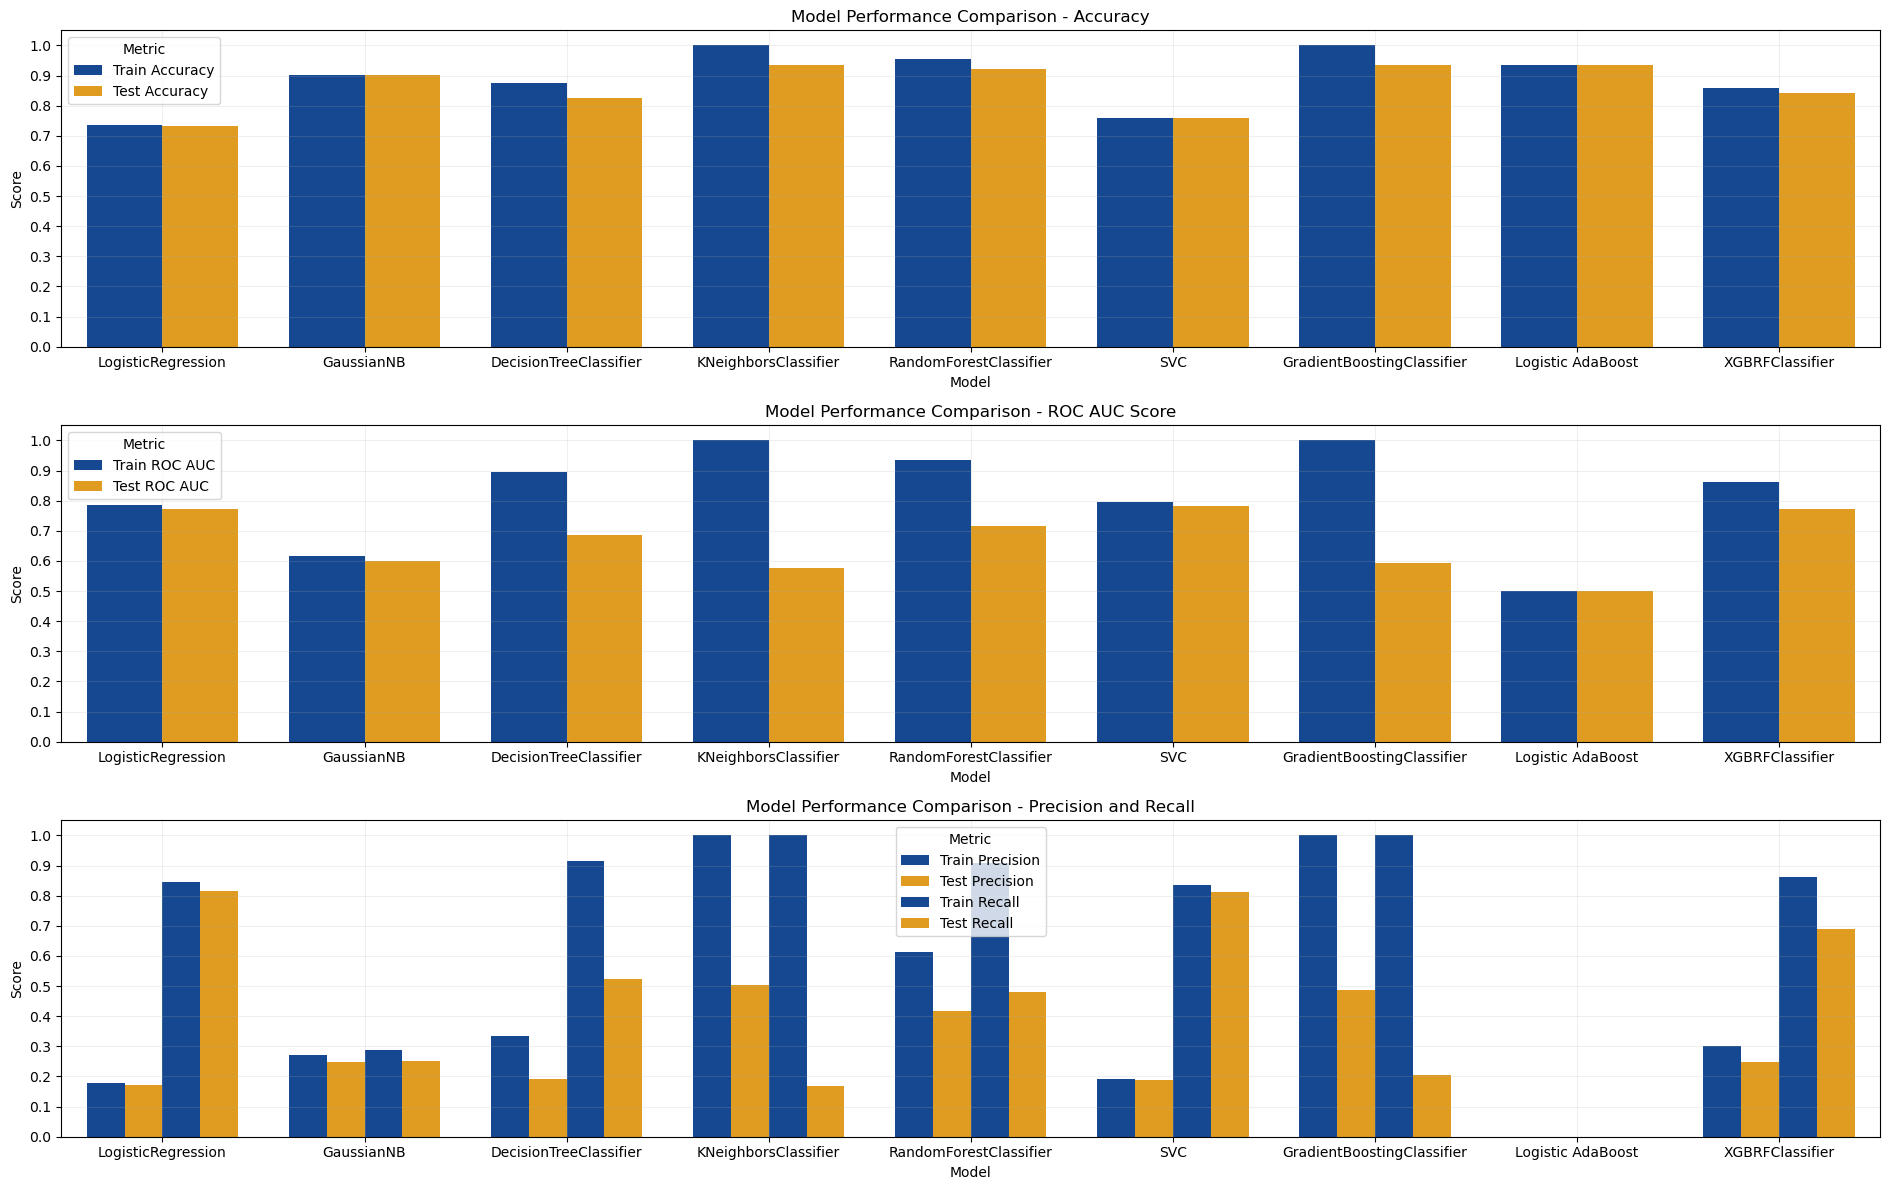

In [50]:
metrics_plot()


From the above we can see that,
- *KNeighborsClassifier* is overfitting.
- *DecisionTreeClassifier*, *RandomForestClassifier*, and *GradientBoostingClassifier* seems to be slightly overfitting.
- *RandomForestClassifier* shows a good balance of precision and recall, but is a slight overfit.
- *GaussianNB* seems to be underfitting.
- *LogisticRegression*, *SVC*, *XGBRFClassifier* are providing comparable performance, but lack precision.
- *RandomForestClassifier* seems to be decent choice with some fine tuning.


### Model Pipeline

*NOTE: Parameter tuning was done earlier and to cut down the computation costs and time, the flag was set to `False`.*

In [51]:
do_hyperparameter_optimisation = False


In [52]:
if do_hyperparameter_optimisation is True:
    imputer = KNNImputer()
    scaler = MinMaxScaler()
    dim_red = PCA(random_state=42)
    classifier = RandomForestClassifier(random_state=42, n_jobs=n_jobs)
    feature_selector = RFE(
        estimator=rfe_estimator, n_features_to_select=rfe_selector.n_features_)

    pipline_steps = [
        ("imputer", imputer),
        ("scaler", scaler),
        ("dim_red", dim_red),
        ("feature_selector", feature_selector),
        ("classifier", classifier)
    ]
    model_pipeline = Pipeline(steps=pipline_steps)

    param_grid = {
        "imputer__n_neighbors": [3, 5],
        "imputer__weights": ["distance"],
        "dim_red__n_components": [0.9, 0.95, 0.99],
        "dim_red__svd_solver": ["full"],
        "feature_selector__estimator__class_weight": ["balanced"],
        "feature_selector__estimator__criterion": ["entropy"],
        "feature_selector__estimator__min_samples_split": [5, 10],
        "feature_selector__estimator__min_samples_leaf": [2, 4],
        "classifier__class_weight": ["balanced"],
        "classifier__criterion": ["gini", "entropy"],
        "classifier__max_depth": [None, 5, 10],
        "classifier__min_samples_split": [5, 10],
        "classifier__min_samples_leaf": [2, 4]
    }

    grid_search = GridSearchCV(
        estimator=model_pipeline,
        cv=StratifiedKFold(n_splits=5),
        param_grid=param_grid,
        scoring="roc_auc",
        return_train_score=True,
        n_jobs=n_jobs,
        verbose=1
    )

    grid_search.fit(X_train_raw, y_train)

    model_pipeline = grid_search.best_estimator_

    print("Best hyperparameters: ")
    print(json.dumps(grid_search.best_params_, indent=2))


In [53]:
if do_hyperparameter_optimisation is False:
    imputer = KNNImputer(n_neighbors=5, weights="distance")
    scaler = MinMaxScaler()
    dim_red = PCA(n_components=0.99, svd_solver="full", random_state=42)
    classifier = RandomForestClassifier(
        class_weight="balanced", criterion="entropy",
        min_samples_split=5, min_samples_leaf=4,
        random_state=42, n_jobs=n_jobs)
    feature_selector = RFE(
        estimator=rfe_estimator, n_features_to_select=rfe_selector.n_features_)

    pipline_steps = [
        ("imputer", imputer),
        ("scaler", scaler),
        ("dim_red", dim_red),
        ("feature_selector", feature_selector),
        ("classifier", classifier)
    ]
    model_pipeline = Pipeline(steps=pipline_steps)

    model_pipeline.fit(X_train_raw, y_train)


Precision Recall Curve

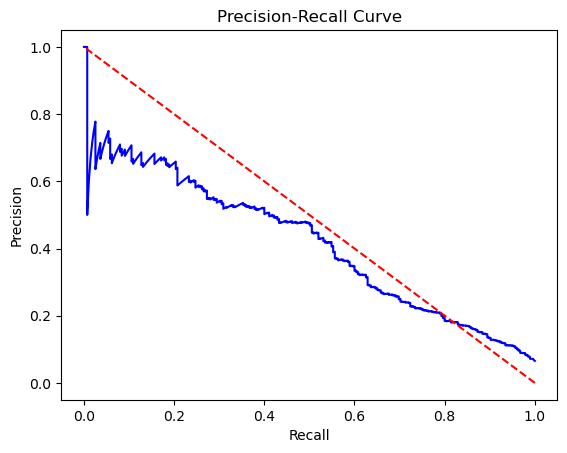

In [54]:
y_scores = model_pipeline.predict_proba(X_test_raw)
y_scores = y_scores[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, linestyle='-', color='blue')
plt.plot([1, 0], [0, 1], linestyle='--', color='red')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.show()


The model seems to be a bit underperforming, but we can finalize this model pipeline for our final predictions.

### Predictions

Reading the unseen data

In [55]:
unseen = pd.read_csv(
    "https://raw.githubusercontent.com/rahul-nanwani/TelecomChurn/master/dataset/test.csv")


In [56]:
unseen.shape


(30000, 171)

Impute the required values before prediction

In [57]:
columns_to_impute = [
    "total_rech_data_6",
    "total_rech_data_7",
    "total_rech_data_8",
    "av_rech_amt_data_6",
    "av_rech_amt_data_7",
    "av_rech_amt_data_8",
    "max_rech_data_6",
    "max_rech_data_7",
    "max_rech_data_8",
]

unseen[columns_to_impute] = unseen[columns_to_impute].fillna(0)


In [58]:
categorical_cols = [
    "night_pck_user_6",
    "night_pck_user_7",
    "night_pck_user_8",
    "fb_user_6",
    "fb_user_7",
    "fb_user_8",
]

unseen[categorical_cols] = unseen[categorical_cols].fillna(-1)

unseen.replace(mapping, inplace=True)


In [59]:
predictions = pd.DataFrame({"id": unseen["id"]})

predictions["churn_probability"] = model_pipeline.predict(
    unseen[X_train_raw.columns])
predictions.head()


,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


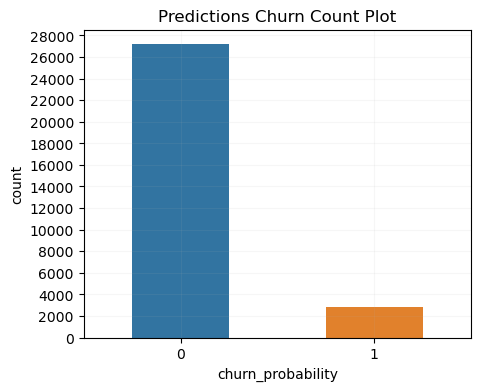

In [60]:
plt.figure(figsize=(5, 4))

sns.countplot(x="churn_probability", data=predictions, width=0.5)

plt.title("Predictions Churn Count Plot")
max_count = max(predictions["churn_probability"].value_counts())
plt.yticks(np.arange(max_count+2000, step=2000))
plt.grid(True, alpha=0.1)

plt.show()


In [61]:
predictions.to_csv("Submission.csv", index=False)


### Conclusion

1. _Improve the customer experience for incoming local calls (loc_ic_mou_8)_:
   - Enhance call quality and network coverage within the customer's local area.
   - Provide attractive call rates or packages for local calls to incentivize customers to stay.
2. _Foster customer engagement through increased incoming calls (total_ic_mou_8)_:
   - Offer personalized and targeted promotions or discounts based on customer preferences and calling patterns.
   - Provide value-added services or rewards for receiving more incoming calls, such as free minutes or additional benefits.
3. _Address concerns related to incoming STD calls (std_ic_mou_8)_:
   - Identify and resolve issues causing dissatisfaction with STD calls, such as call quality or high charges for STD calls.
   - Introduce affordable STD call packages or discounted rates to encourage customers to make more STD calls.
4. _Understand and address specific needs related to incoming ISD calls (isd_ic_mou_8)_:
   - Analyze the reasons behind increased ISD call activity and address any pain points or concerns related to international calling.
   - Offer competitive international calling rates, discounted ISD packages, or value-added services for international calling.
5. _Encourage outgoing call activity (total_og_mou_8)_:
   - Provide attractive calling plans, packages, or offers to encourage customers to make more outgoing calls.
   - Offer benefits or rewards for consistent outgoing call usage, such as loyalty points, discounts, or free minutes.
